# Homework \#8

RANSAC Localization



## Import Modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Load Data
The following data are given:

1.  Database image `data/000000.png`
2.  Keypoints in the database image `data/keypoints.txt`
3.  3D location of the keypoints in the W-frame `data/p_W_landmarks.txt`

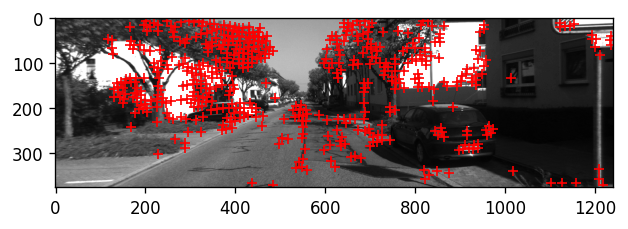

In [2]:
img_database = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
keypoints_database = list(map(tuple, np.loadtxt('data/keypoints.txt', dtype='int')-1)) # list of (row, col)
K = np.loadtxt('data/K.txt')
p_W_landmarks = np.loadtxt('data/p_W_landmarks.txt').T

plt.figure(dpi=120)
plt.imshow(img_database,cmap='gray')
plt.plot(np.array(keypoints_database).T[1,:],np.array(keypoints_database).T[0,:],'r+')

## RANSAC Localization

The following codes regenerate the results dicussed in the class for the first frame. Note that the frame number is defined by the variable `i_frame =1`

In [3]:
W_harris_patch = 4 # size of Harris patch
harris_kappa = 0.08 # parameters of Harris score
W_nms = 8 # size of non-maximum suppresion for keypoints seclection
W_descriptor = 9 # size of descriptor patch
lambda_match = 6 # paramter of descriptor matching
N_keypoint = 1000 # number of keypoints 
N_iter = 1000 # number of RANSAC iteration
tol_inlier = 10 # tolerance of RANSIC inliner in pixels

# 1. imq_database: compute descriptor
descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)

# 2. imq_query: load query image, detect keypoints, and compute descriptor
i_frame = 1
img_query_filename = "data/{:06d}.png".format(i_frame)   
img_query = cv2.imread(img_query_filename,cv2.IMREAD_GRAYSCALE)
harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)

# 3. match descriptors 
match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
index_match = np.where(match>=0)[0].tolist()

# 4. extract matched keypoints and 3D world coordinates
keypoints_query_matched = [keypoints_query[i] for i in index_match]
keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
p_W_matched = p_W_landmarks[:, match[index_match]]

p_matched = np.array(keypoints_query_matched).T 
p_matched = p_matched[[1,0],:] 
p_matched = np.concatenate((p_matched, np.ones((1,p_matched.shape[1])) ), axis=0) 
p_W_matched = p_W_landmarks[:, match[index_match]]
p_W_matched = np.concatenate((p_W_matched, np.ones((1,p_W_matched.shape[1])) ), axis=0) 

# 5. estimate pose with RANSAC
R, T, M, N_inliers, i_inliers = mae6292.estimate_pose_RANSAC_DLT(p_matched, p_W_matched, K, N_iter, tol_inlier, display_iter=True)
print(-R.T@T)


i_iter=44, N_inliers=1, w=0.00
i_iter=91, N_inliers=2, w=0.01
i_iter=120, N_inliers=150, w=0.50
i_iter=136, N_inliers=195, w=0.65
i_iter=152, N_inliers=229, w=0.76
i_iter=652, N_inliers=230, w=0.76
[[-0.00684574]
 [-0.01574125]
 [ 0.69763081]]


## Visualization

For the given estimated pose, the following codes visualize

1. the image frame with the matched keypoints
2. the top view of the estimated pose represented by an axes frame, and the keypoints, where the matched keypoints are denoted by a red marker

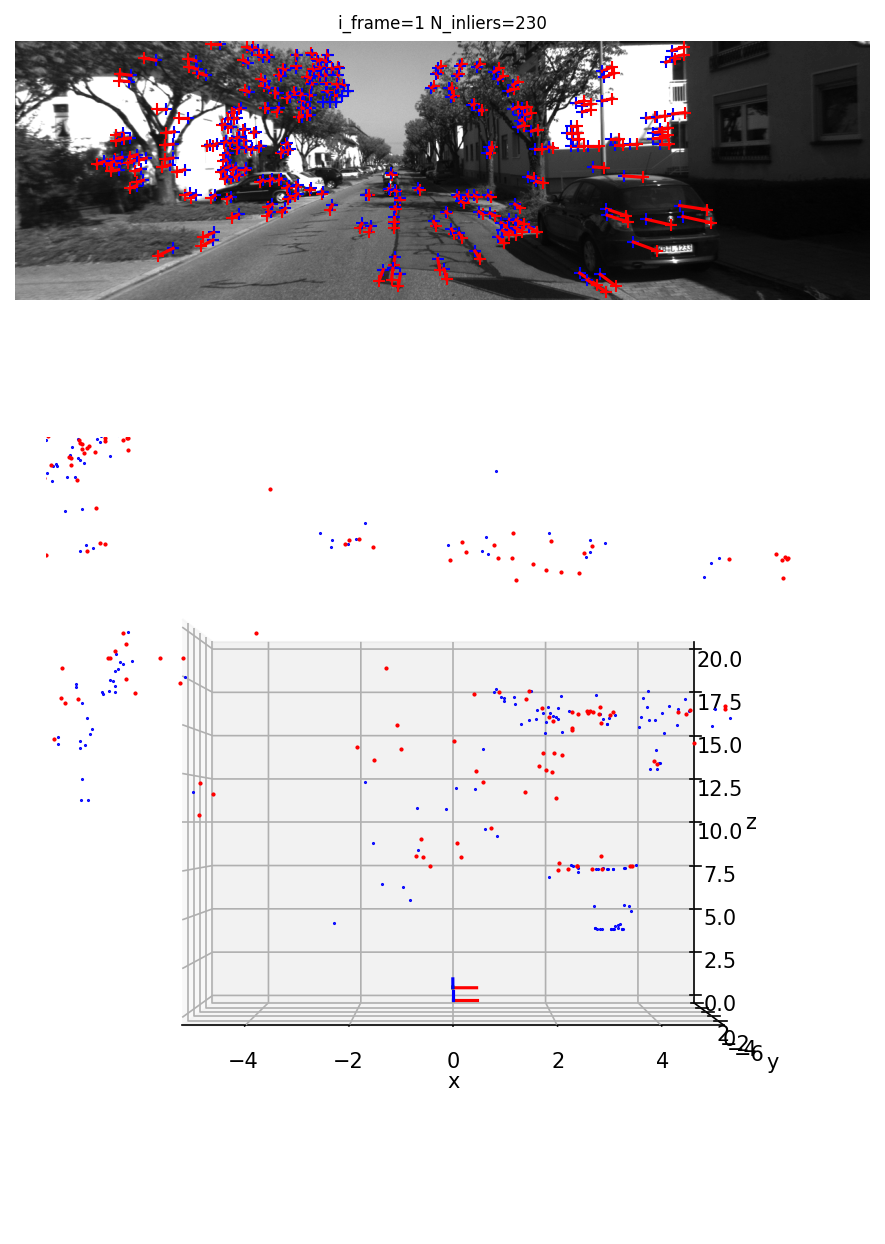

In [4]:
%matplotlib inline
fig = plt.figure(dpi=150,figsize=(6,10))

fig.add_subplot(2, 1, 1)
plt.imshow(img_query,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
for i in i_inliers:
    v_q, u_q = keypoints_query_matched[i] # matched keypoints on img1
    v_d, u_d = keypoints_database_matched[i] # matched keypoints on img
    plt.plot(u_q, v_q, 'r+') 
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')
plt.title('i_frame='+str(i_frame)+' N_inliers='+str(N_inliers), fontsize=8)

ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.plot(p_W_landmarks[0,:],p_W_landmarks[1,:],p_W_landmarks[2,:],'b.',markersize=1)
ax.plot(p_W_matched[0,i_inliers],p_W_matched[1,i_inliers],p_W_matched[2,i_inliers],'ro',markersize=1)
ax.set_xlim(-5,5)
ax.set_zlim(0,20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0., azim=-90)
mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)),axis_length=0.5)
mae6292.draw_frame(ax, R,T,axis_length=0.5)
plt.tight_layout()


## Problem 1

### (a) RANSAC DLT

We are going to apply the above RANSAC DLT localization for the subsequent 9 frames, and study its performance. 

1. Using a `for loop` repeat the above **RANSAC Localzation** (without **Visualization**) for the frames from `i_frame=1` to `i_frame=9`
2. Redefine `N_inliers` as an array or a list of 9 integers. Then, for each frame, save the number of inlliers to `N_inliers`
3. Generate a 2D plot for `N_inliers` with respect to `i_frame`, i.e., the horizontal axis is from 1 to 9, and the vertical axis is the number of N_inliers. Save it into `prob1.png`

Note that the results might alter everytime you run the code, because of the random selection in RANSAC. Repeat this several times and choose a reasonable result.  

### (b) Discussion

Brifely discuss why the number of inliners decreases.

## Problem 2

### (a) Tuning Parameters

Adjust the following three parameters, 
```
N_keypoint = 1000
N_iter = 1000
tol_inlier = 10
```
to increase the number of inliers from your results of **Problem 1** as much as you can. Save the selected paramters in the code. It is expected that everyone has a unique choice.

In [8]:
N_keypoint = 1000 # number of keypoints 
N_iter = 1000 # number of RANSAC iteration
tol_inlier = 10 # tolerance of RANSIC inliner in pixels



### (b) Visualization

For your chosen paramters, visualize the results using the code provided at the **Visualization** section. Save the image as `prob2_?.png`, where `?` corresponds to `i_frame`

### How To Submit

Attach

1.  `prob1.png`
2.  `prob2_1.png` ... `prob2_9.png`